In [1]:
!pwd

/content


In [3]:
!pip install tqdm

In [1]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-11-28 16:06:23--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.2.14.81, 52.71.139.107, 34.235.253.190, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.2.14.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  14.5MB/s    in 0.9s    

2019-11-28 16:06:25 (14.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
!pip install -q kaggle

**Download data:**

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  

kaggle.json


In [6]:
!kaggle competitions download -c histopathologic-cancer-detection -p ./data


  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 93.4MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 153MB/s]
100% 1.30G/1.30G [00:07<00:00, 207MB/s]
100% 1.30G/1.30G [00:07<00:00, 188MB/s]
100% 4.97G/4.98G [00:26<00:00, 201MB/s]
100% 4.98G/4.98G [00:26<00:00, 199MB/s]


In [0]:
!mkdir train
!unzip -q ./data/train.zip -d ./data/train/

In [8]:
!unzip ./data/train_labels.csv.zip

Archive:  ./data/train_labels.csv.zip
  inflating: train_labels.csv        


In [0]:
#!ls ./data/train

**CODE:**

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)



In [0]:
get_ipython().system_raw('./ngrok http 6006 &')



In [11]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://c5f63145.ngrok.io


In [12]:
import numpy as np 
import pandas as pd 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm_notebook
import cv2
import matplotlib.pyplot as plt
import os
import shutil
from glob import glob 
from skimage.io import imread
import gc

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import TensorBoard

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score



"""from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense"""


Using TensorFlow backend.


'from keras.layers.normalization import BatchNormalization\nfrom keras.layers.convolutional import Conv2D\nfrom keras.layers.convolutional import MaxPooling2D\nfrom keras.layers.core import Activation\nfrom keras.layers.core import Flatten\nfrom keras.layers.core import Dropout\nfrom keras.layers.core import Dense'

In [13]:
base_tile_dir = './data/train/'
df_images = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.tif'))})
df_images['id'] = df_images.path.map(lambda x: x.split('/')[3].split(".")[0])
labels = pd.read_csv("./train_labels.csv")
df_merged = df_images.merge(labels, on = "id")

# dropping some bad data
df_merged = df_merged[df_merged['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
df_merged = df_merged[df_merged['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

df_merged.head(3)

,path,id,label
0,./data/train/527409d75b6548b6922034239d239b631...,527409d75b6548b6922034239d239b63121bc26c,0
1,./data/train/f0e72f8bdc9d74a3194576958b9f2b46d...,f0e72f8bdc9d74a3194576958b9f2b46d075a12f,0
2,./data/train/81fd1cfe0f06988b09e01c5d2b25f83d5...,81fd1cfe0f06988b09e01c5d2b25f83d5318381c,0


In [14]:
len(df_merged)

220023

In [15]:
len(df_images)

220025

**Plotting example images with their assigned label:**

In [0]:
def load_data(num,data_frame):
    
    X = np.zeros([num,96,96,3],dtype=np.uint8) 
    y = np.squeeze(data_frame.as_matrix(columns=['label']))[0:num]
    
    for i, row in tqdm_notebook(data_frame.iterrows(), total=num):
        if i == num:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

In [17]:
N=10000
X,y = load_data(num=N,data_frame=df_merged) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


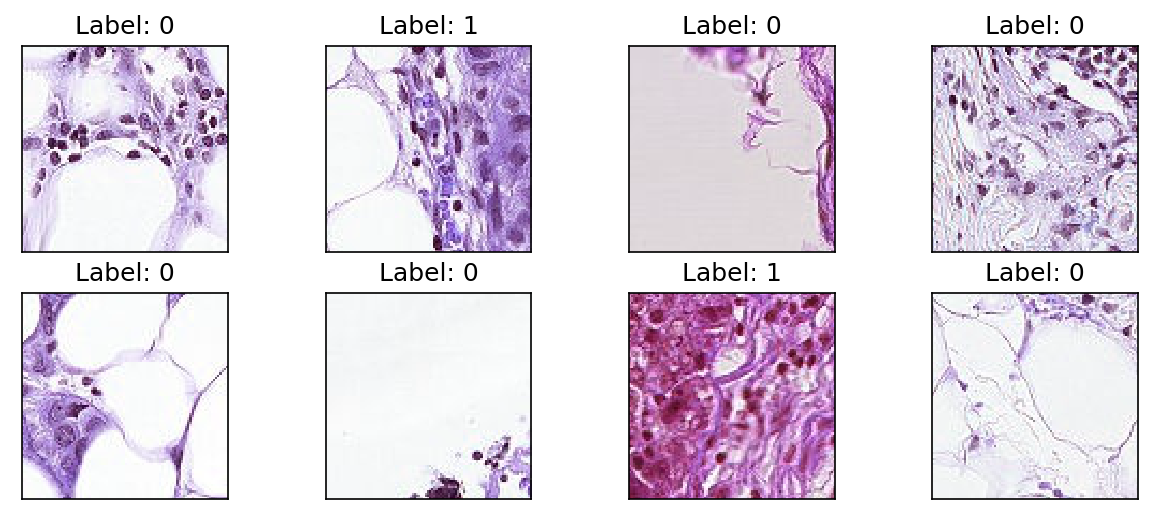

In [18]:
fig = plt.figure(figsize=(10, 4), dpi=150)
np.random.seed(100) 
for plotNr,idx in enumerate(np.random.randint(0,N,8)):
    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[]) 
    plt.imshow(X[idx]) 
    ax.set_title('Label: ' + str(y[idx])) 

**Looking at the data distribution**

Text(0, 0.5, 'num of samples')

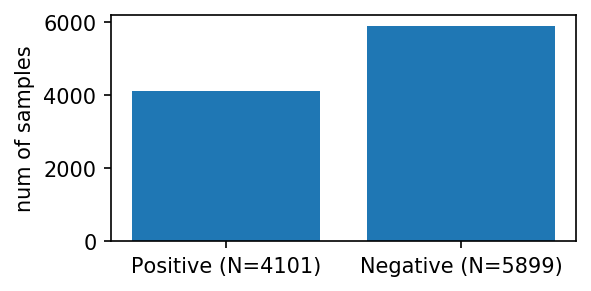

In [19]:
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]); 
plt.xticks([1,0],["Negative (N={})".format((y==0).sum()),"Positive (N={})".format((y==1).sum())]);
plt.ylabel("num of samples")

In [0]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

**Comparing the distribution of pixel values for each RGB color channel individually and all channels together**

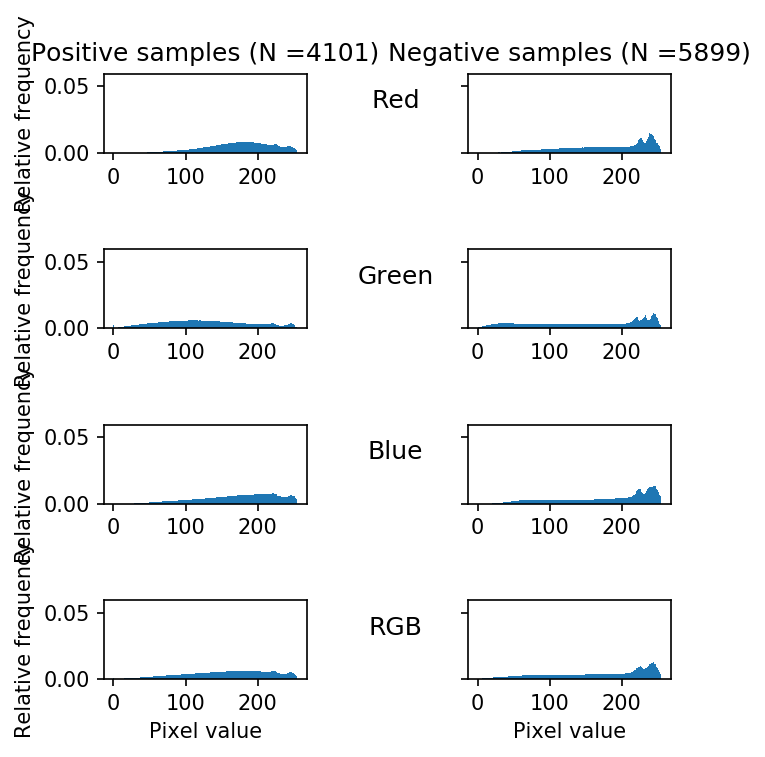

In [21]:
nr_of_bins = 256 
fig,axs = plt.subplots(4,2,sharey=True,figsize=(5,5),dpi=150)


axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)


axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)


axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

**OBSERVATIONS:**


*   Negative samples have higher,brighter pixel values, especially in the green color channel.
*   Positive samples have a darker green channel than red and blue while this is not true for the negative samples. 
*   Very dark pixels for both sample sets mostly only present in the green channel.
*   Relatively high frequency of the pixel value 255. These can likely be attributed to the bright white image regions present in some images.






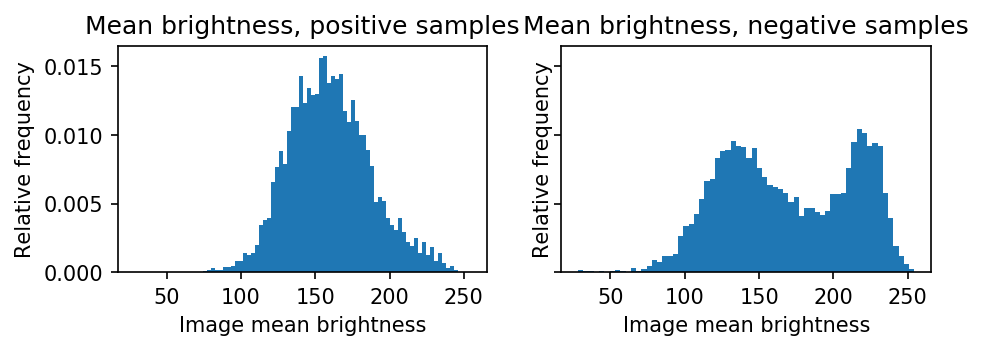

In [22]:
num_of_bins = 64 
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(7,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=num_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=num_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

**Conclusions:**



*   There are differences in the distributions of pixel values and mean image brightness between positive and negative samples and our model can likely use this.
*   Some images contain very bright regions, which are likely artifacts of the recording process. They are almost equally distributed between positive and negative samples and, hence, probably not easily usable as a feature.
*   We have about 50% more negative than positive samples. We will resample the data before training to have equal proportions of negative and positive samples.








In [23]:
len(df_merged)

220023

In [24]:
len(df_images)

220025

In [25]:
len(labels)

220025

**Preparing Data for Training**

In [0]:
#!rm -r ./base_dir/train
#!rm -r ./base_dir/valid

In [0]:
SAMPLE_SIZE = 80000 # use only 80k negative examples

# Take a random sample of class 0 with size equal to num samples in class 1 to get rid of class imbalance in data
df_zeros = df_merged[df_merged['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
df_ones = df_merged[df_merged['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)
df_merged = shuffle(pd.concat([df_zeros, df_ones], axis=0).reset_index(drop=True))
y = df_merged['label']
train_df, val_df = train_test_split(df_merged, test_size=0.10, random_state=101, stratify=y)




In [0]:
train_path = './base_dir/train'
valid_path = './base_dir/valid'
for folder in [train_path, valid_path]:
    for lab in ["0", "1"]:
        os.makedirs(os.path.join(folder, lab))

In [29]:
df_merged.set_index('id', inplace=True)
df_merged.head()

,path,label
id,,
2695da5ad1498c8db015441b82063ef45640b032,./data/train/2695da5ad1498c8db015441b82063ef45...,0
eaac5e6839dfeee04652c216e1a188b2eb897061,./data/train/eaac5e6839dfeee04652c216e1a188b2e...,1
1b8ef06091994419d7a5e06e4e2a2bec66ae904b,./data/train/1b8ef06091994419d7a5e06e4e2a2bec6...,1
6df35b52fd52bb864da588a8ccc375e9ca68c926,./data/train/6df35b52fd52bb864da588a8ccc375e9c...,0
fa4ce49f6fcee7b872272babeed436344fa6108c,./data/train/fa4ce49f6fcee7b872272babeed436344...,1


In [30]:
len(df_merged)

160000

In [0]:
#!ls ./base_dir/valid/0 | wc -l


**Creating training and validation data in separate directories**

In [0]:
for image in train_df['id'].values:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    label = str(df_merged.loc[image,'label']) # get the label for a certain image
    src = os.path.join('./data/train', fname)
    dst = os.path.join(train_path, label, fname)
    shutil.copyfile(src, dst)



In [0]:
for image in val_df['id'].values:
    fname = image + '.tif'
    label = str(df_merged.loc[image,'label']) # get the label for a certain image
    src = os.path.join('./data/train', fname)
    dst = os.path.join(valid_path, label, fname)
    shutil.copyfile(src, dst)

**Create Data Generators**

In [33]:
IMAGE_SIZE = 96
num_train_samples = len(train_df)
num_val_samples = len(val_df)
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

data_generator = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_generator = data_generator.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

valid_generator = data_generator.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

#shuffle=False causes the test dataset to not be shuffled
test_generator = data_generator.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [34]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

model1 = Sequential()
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model1.add(Conv2D(first_filters, kernel_size, use_bias=False))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(MaxPool2D(pool_size = pool_size)) 
model1.add(Dropout(dropout_conv))
model1.add(Conv2D(second_filters, kernel_size, use_bias=False))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(Conv2D(second_filters, kernel_size, use_bias=False))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(MaxPool2D(pool_size = pool_size))
model1.add(Dropout(dropout_conv))
model1.add(Conv2D(third_filters, kernel_size, use_bias=False))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(Conv2D(third_filters, kernel_size, use_bias=False))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(MaxPool2D(pool_size = pool_size))
model1.add(Dropout(dropout_conv))
model1.add(Flatten())
model1.add(Dense(256, use_bias=False))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(Dropout(dropout_dense))
model1.add(Dense(1, activation = "sigmoid"))

model1.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [35]:

"""
#from keras import backend as K

model2 = Sequential()
model2.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
model2.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model2.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model2.add(Dropout(0.3))
model2.add(MaxPooling2D(pool_size = 3))

model2.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model2.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model2.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model2.add(Dropout(0.3))
model2.add(MaxPooling2D(pool_size = 3))

model2.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model2.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model2.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model2.add(Dropout(0.3))
model2.add(MaxPooling2D(pool_size = 3))

model2.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model2.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model2.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model2.add(Dropout(0.3))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation = 'sigmoid'))
model2.summary()
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])"""

"\n#from keras import backend as K\n\nmodel2 = Sequential()\nmodel2.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))\nmodel2.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))\nmodel2.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))\nmodel2.add(Dropout(0.3))\nmodel2.add(MaxPooling2D(pool_size = 3))\n\nmodel2.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))\nmodel2.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))\nmodel2.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))\nmodel2.add(Dropout(0.3))\nmodel2.add(MaxPooling2D(pool_size = 3))\n\nmodel2.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))\nmodel2.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))\nmodel2.add(Conv2D(filters = 64, kernel_size = 3, paddi

In [0]:
model = model1

In [37]:
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         #batch_size=batch_size,
                         write_images=True)
#earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
#reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
history = model.fit_generator(train_generator, steps_per_epoch=train_steps, 
                    validation_data=valid_generator,
                    validation_steps=val_steps,
                    epochs=10,
                    callbacks=[tbCallBack])
                   





Epoch 1/10
4500/4500 [==============================] - 395s 88ms/step - loss: 0.4254 - acc: 0.8120 - val_loss: 0.3578 - val_acc: 0.8414

Epoch 2/10
4500/4500 [==============================] - 347s 77ms/step - loss: 0.3455 - acc: 0.8543 - val_loss: 0.3047 - val_acc: 0.8682
Epoch 3/10
4500/4500 [==============================] - 349s 78ms/step - loss: 0.3023 - acc: 0.8768 - val_loss: 0.3474 - val_acc: 0.8496
Epoch 4/10
4500/4500 [==============================] - 349s 78ms/step - loss: 0.2751 - acc: 0.8903 - val_loss: 0.2752 - val_acc: 0.8874
Epoch 5/10
4500/4500 [==============================] - 348s 77ms/step - loss: 0.2584 - acc: 0.8969 - val_loss: 0.3447 - val_acc: 0.8431
Epoch 6/10
4500/4500 [==============================] - 347s 77ms/step - loss: 0.2469 - acc: 0.9027 - val_loss: 0.2815 - val_acc: 0.8782
Epoch 7/10
4500/4500 [==============================] - 347s 77ms/step - loss: 0.2392 - acc: 0.9076 - val_loss: 0.3392 - val_acc: 0.8557
Epoch 8/10
4500/4500 [==============

In [38]:
# Save the trained model

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 

Saved model to disk


In [39]:
# load json and create model
"""json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error',metrics=['accuracy','mse'])
model=loaded_model"""

'json_file = open(\'model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\n# load weights into new model\nloaded_model.load_weights("model.h5")\nprint("Loaded model from disk")\n \n# evaluate loaded model on test data\nloaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=\'mean_squared_error\',metrics=[\'accuracy\',\'mse\'])\nmodel=loaded_model'

**PREDICTIONS (Inference)**

In [40]:
# make a prediction
y_pred_keras = model.predict_generator(test_generator, steps=len(val_df), verbose=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_generator.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

16000/16000 [==============================] - 60s 4ms/step


0.9782515

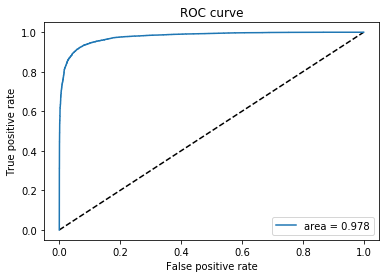

In [41]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [42]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_generator.classes, y_pred_keras>0.5)

array([[7702,  298],
       [ 974, 7026]])

**REFERENCES USED:**

https://www.kaggle.com/c/histopathologic-cancer-detection/data

https://www.kaggle.com/c/histopathologic-cancer-detection/notebooks

https://github.com/gmontamat/histopathologic-cancer-detection/blob/master/resnet50.ipynb

